In [63]:
# correct implementation of f_eq(rho_in, u_N) still to do, simulations werent working with the current version, see cell 62

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# reflect points who get "dry" by streaming representing boundaries. e.g if you are at the bottom, reflect 4 to 2, i.e. f[2, 1, ] = f[4, 0, ]
# that is overwriting the streaming step
NX = 20
NY = 20
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])# weights, note that the last four (edges) 
# are the interpolation points with the highest velocity; weights influence probability density
c_ij = np.array([[0, 1,  0, -1, 0, 1, -1, -1, 1], [0, 0, 1, 0, -1, 1, 1, -1, -1]])# velocities x and y component

In [2]:
def dens_lattice_point(f_vxy):
    return np.einsum('vxy -> xy', f_vxy)

def vel_field_lattice_point(f_vxy):
    rho = dens_lattice_point(f_vxy)
    v = np.einsum('ij, ixy -> jxy', c_ij.T, f_vxy)
    return v / rho

def stream(f_ijk):
    # define a velocity vector containing all shifting directions
    c_ij = [[0, 0],[0, 1],[-1, 0],[0, -1], [1, 0], [-1, 1], [-1, -1], [1, -1], [1, 1]]
    for p in range(1,9):
        f_ijk[p] = np.roll(f_ijk[p], shift=c_ij[p], axis=(0,1))
    return f_ijk

In [3]:
f_eq_vxy = np.zeros((9, NX+2, NY+2)) # reshape?

def equi_dist(rho, av_vel):
    u_abs = np.einsum('inm, inm -> nm',abs(av_vel),abs(av_vel))
    for j in range(9):
        scal = np.einsum('j, jnm -> nm', c_ij.T[j], av_vel)
        f_eq_vxy[j] = w_i[j] * rho *(1 + 3*scal + 9/2*scal**2- 3/2 * u_abs)
    return f_eq_vxy

def comp_new_dist(f_vxy, f_eq, omega = 1):
    f_vxy += omega * (f_eq - f_vxy)
    # omega describes the impact of the relaxation
    return f_vxy

In [4]:
def moving_wall(vel):
    #calculate the values from Mohamad, used for the simulation of the moving wall
    rho_N = f_inm[0, 1, 1:NY+1] + f_inm[1, 1, 1:NY+1] + f_inm[3, 1, 1:NY+1]  + 2 * (f_inm[2, 1, 1:NY+1] + f_inm[6, 1, 1:NY+1] + f_inm[5, 1, 1:NY+1])
    f_inm[4, 1, :] = f_inm[2, 0, :]
    # velocity of moving wall
    u_N = vel

    f_inm[7, 1, 1:NY+1] = f_inm[5, 0, 2:NY+2]
    f_inm[7, 1, 1:NY+1] += 1/2 * (f_inm[1, 1, 1:NY+1] - f_inm[3, 1, 1:NY+1]) - 1/2 * rho_N * u_N
    f_inm[8, 1, 1:NY+1] = f_inm[6, 0, 0:NY]
    f_inm[8, 1, 1:NY+1] += 1/2 * (f_inm[3, 1, 1:NY+1] - f_inm[1, 1, 1:NY+1]) + 1/2 * rho_N * u_N
    # this operations should only change one X-line, but graphics show change in all lines
    #print(f_inm[1, 1, 1:NY+1] - f_inm[3, 1, 1:NY+1])

In [21]:
def bounce_back_south():
    # bottom boundary implemented as hard wall, reflecting the streaming impulses; this has to happen after the streaming step
    f_inm[2, NX, :] = f_inm[4, NX+1, :]

        # northeast bounce back from left down corner to right down corner of wet nodes
    f_inm[5, NX, 1:NY+1] = f_inm[7, NX+1, 0:NY]
        # northwest bounce back
    f_inm[6, NX, 1:NY+1] = f_inm[8, NX+1, 2:NY+2]
    # those corrections are no longer needed as we overwrite the dry nodes x0, xN with the pressure nodes
    #f_inm[7, 2:NX+1, NY] = f_inm[7, 2:NX+1, 0]
    #f_inm[7, 2:NX+1, 0] = 0
    #f_inm[7, NX+1, :] = 0
    #f_inm[8, 2:NX+1, 1] = f_inm[8, 2:NX+1, NX+1]
    #f_inm[8, 2:NX+1, NX+1] = 0
    #f_inm[8, NX+1, :] = 0

def bounce_back_north():
    # top boundary implemented as hard wall, reflecting the streaming impulses; this has to happen after the streaming step
    f_inm[4, 1, :] = f_inm[2, 0, :] #sharply we only need to set grid point 1:NX+1, but in the dry nodes we dont care for changes, as we set them new before every streaming

        # northeast bounce back from left down corner to right down corner of wet nodes
    f_inm[7, 1, 1:NY+1] = f_inm[5, 0, 2:NY+2]
        # northwest bounce back
    f_inm[8, 1, 1:NY+1] = f_inm[6, 0, 0:NY]
    # those corrections are no longer needed as we overwrite the dry nodes x0, xN with the pressure nodes
    #f_inm[5, 2:NX+1, 1] = f_inm[5, 1:NX, NY+2]
    #f_inm[5, 1:NX, 0] = 0 #upper right dry node not cleared here so far
    #f_inm[5, 0, :] = 0 # now clear it
    #f_inm[6, 1, 1:NY+1] = f_inm[6, 0, 1:NX]


In [55]:
# initalization of f with dry nodes
f_inm = np.einsum('i,jk -> ijk', w_i, np.ones((NX + 2, NY + 2)))# product of two arrays
f_inm[:, 0, :] = 0
f_inm[:, NX+1, :] = 0
f_inm[:, :, 0] = 0
f_inm[:, :, NY + 1] = 0

In [56]:
rho = np.ones((NX+2, NY+2))
#rho[:,:] = 1
u = np.zeros((2,NX+2, NY+2))

f_inm_eq = equi_dist(rho, u)
f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 0.3)

In [62]:
#do a function working with u_N, the column of the x-velocities

# also possible: do a reshape command for the einsum in the usual equilibrium function

def equi_dist_in(rho, u):
    u_abs = np.einsum('inm, inm -> nm',u,u)
    for j in range(9):
        scal = np.einsum('j, jnm -> nm', c_ij.T[j], av_vel)
        f_eq_vxy[j] = w_i[j] * rho *(1 + 3*scal + 9/2*scal**2- 3/2 * u_abs)
    return f_eq_vxy

In [58]:
# for all channels do the Poiseuille Flow
def Poiseuille_Flow():
    p_out = 1
    p_in = 0.99
    delta_p = p_out - p_in
    cs_2 = 1/3
    rho_in = (p_out + delta_p) / cs_2
    rho_out = p_out / cs_2
    f_eq_in = equi_dist_in(rho_in, u[:,:,NY]) # compute f_eq(rho_in, u_N)
    f_eq_out = equi_dist_in(rho_out, u[:,:,0])
    f_eq = equi_dist(rho, u)

    for i in range(1,9):
        #f_inm[i, :, 0] = f_eq_out[i, :, NY] + (f_inm[i, :, NY] - f_eq[i, :, NY])
        f_inm[i, :, 0] = f_eq_in + (f_inm[i, :, NY] - f_eq[i, :, NY])
        f_inm[i, :, NY+1] = f_eq_out + (f_inm[i,:,1] - f_eq[i, : , 1])
        #f_inm[i, :, NY+1] = f_eq_in[i, :, 1] + (f_inm[i,:,1] - f_eq[i, : , 1]) 
        
# have to check if the extra layer needed here is colliding with the so far implementation
#check in what order the parts have to be computed, maybe the equilibs before the streaming

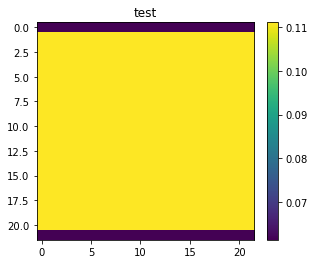

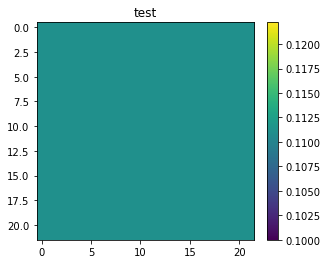

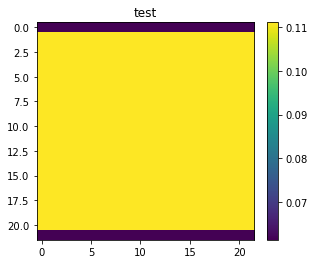

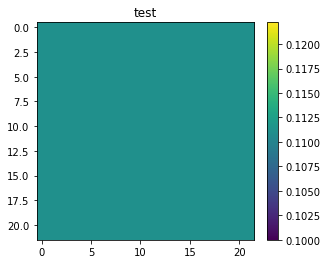

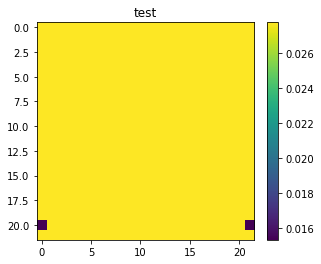

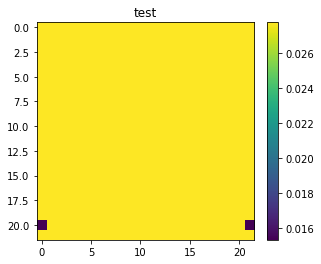

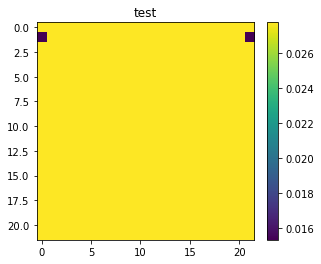

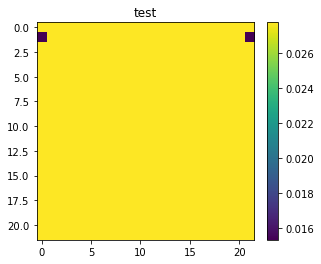

In [25]:
Poiseuille_Flow()
f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 0.2)
f_inm = stream(f_inm)
bounce_back_south()
bounce_back_north()
for i in range(8):
    fig, ax = plt.subplots()
    im = ax.imshow(f_inm[i+1])
    plt.title("test")
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.show()

In [60]:
#simulation 
# implement dry nodes as 9 x NX + 2 x NY + 2 array for the "sourrounding" of our simulation domain. Then check for the "boundary"
# nodes if they will be streamed to a dry node and simulate the boudary impact


amp_x = []
amp_y = []


for t in tqdm(range(200), "Simulating"):
    
    
    f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 0.2)
    Poiseuille_Flow()

    f_inm = stream(f_inm)
    # moving wall, bounceback and corrections in the dry nodes
    #f_inm[1, 1:NX+1, 1] = f_inm[1, 1:NX+1, NY+1]

    #f_inm[3, 1:NX+1, NY] = f_inm[3, 1:NX+1, 0]
    #f_inm[4, 1, 1:NY+1] = f_inm[4, NX+1, 1:NY+1]
    #moving_wall(0.05)
    #f_inm[2, NX, 1:NY+1] = f_inm[2, 0, 1:NY+1]
    
    bounce_back_south()
    bounce_back_north()
    #clear the dry nodes after calculations
    
    rho = dens_lattice_point(f_inm)
    
    u = vel_field_lattice_point(f_inm)

    f_inm_eq = equi_dist(rho, u)
    
    #if t%10 == 0:
        #u_cut_x = u[0,:,5]
        #u_cut_y = u[1,5,5]
        #amp_x.append(u_cut_x)
        #amp_y.append(u_cut_y)
    if t%20 == 0:
        u_cut_x = u[0,1:NX+1,10] #cut in x-direction
        plt.figure()
        plt.plot(np.arange(NX), u_cut_x)
        plt.title("Velocity Development")
        plt.xlabel("y")
        plt.ylabel("velocity")
        plt.savefig("decay_plot.png")
        plt.show()

Simulating:   0%|                                       | 0/200 [00:00<?, ?it/s]


ValueError: einstein sum subscripts string contains too many subscripts for operand 0